# Rejection ABC

This example shows you how to perform rejection ABC on a time series from the stochastic degradation model.

First we generate some data using the suggested parameters for this model

In [1]:
%load_ext line_profiler

import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load a forward model

model = toy.StochasticDegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 50, 100)
values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior(
    [0.0],
    [0.3]
)

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)

We can visualize the generated data against the expected data below

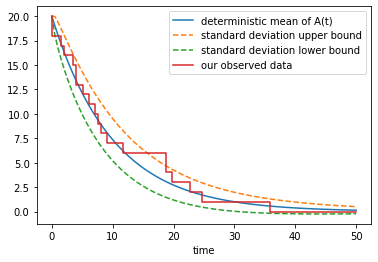

In [2]:
mean = model.mean(real_parameters, times)
variance = model.variance(real_parameters, times)
std_dev = np.sqrt(variance)

plt.plot(times, mean, '-', label = 'deterministic mean of A(t)')
plt.plot(times, mean + std_dev, '--', label = 'standard deviation upper bound')
plt.plot(times, mean - std_dev, '--', label = 'standard deviation lower bound')

plt.step(times, values, label = 'our observed data')
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.show()

We now create a Sequential ABC Controller, this takes a number of optional parameters but left as default it will carry out the Toni 2019 ABC-SMC sampling algorithm

In [3]:
abc = pints.SequentialABCController(error_measure, log_prior)

In [4]:
# set initial threshold
abc.set_initial_threshold(3)

# set cooling schedule to half temp at every time
abc.set_cooling_schedule(0.5)

# set cooling limit to stop when we would only cool by 0.1
abc.set_cooling_limit(0.375)

# set target number of samples
abc.set_n_target(300)

# set max number of iterations
abc.set_max_iterations(1000*abc._n_target)

# log to screen
abc.set_log_to_screen(True)

# %lprun -f abc._calculate_weights 
samples = abc.run()
print('Done!')

Using Rejection ABC
Running in sequential mode.
Time 0: 300 samples found at threshold 3 within 714 evals
Samples found, weighting
Time 1: 300 samples found at threshold 1.5 within 1467 evals
Samples found, weighting
Time 2: 300 samples found at threshold 0.75 within 108507 evals
Eval. Time m:s
110688   1:03.9
Sampling Complete
Done!


We can then see how our series of intermediate distributions did at approximating the actual parameters by plotting them as histograms

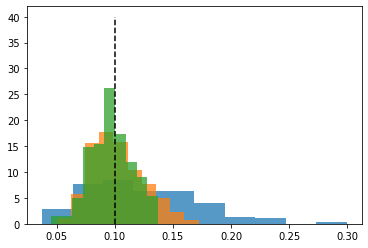

In [5]:
kwargs = dict(alpha=0.75, density=True, stacked=True)

for i in range(len(samples)-1):
    plt.hist([x[0] for x in samples[i][:]], **kwargs)

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=40)
plt.show()

_or if you have seaborn installed we can see a prettier version here_

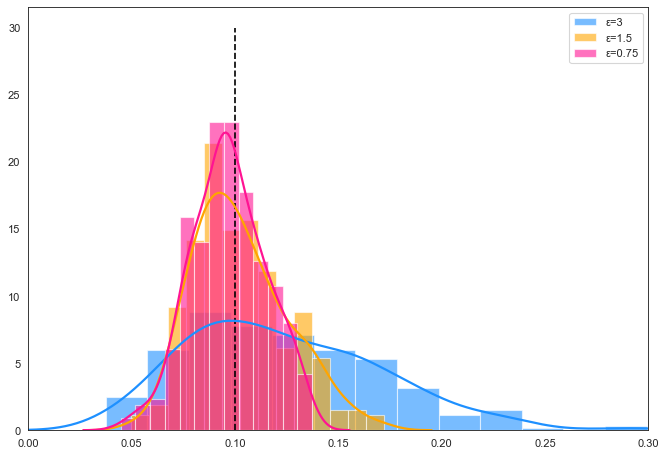

In [6]:
sns.set_style("white")
# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi=80)
sns.distplot([x[0] for x in samples[0][:]], color="dodgerblue", label="ε=3", **kwargs)
sns.distplot([x[0] for x in samples[1][:]], color="orange", label="ε=1.5", **kwargs)
sns.distplot([x[0] for x in samples[2][:]], color="deeppink", label="ε=0.75", **kwargs)
plt.xlim(0,0.3)
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=30)
plt.legend();

Now we can compare the recovered parameters to the real parameters used to generate this data

Observed params: [0.09611705]
Actual params: [0.1]


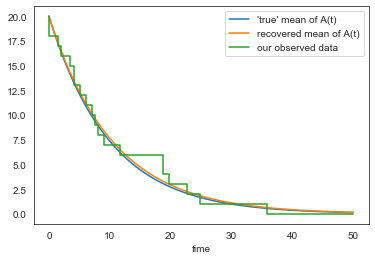

In [7]:
import statistics
observed_k = statistics.median(samples[len(samples)-2][:])
print("Observed params: " + str(observed_k))
print("Actual params: " + str(model.suggested_parameters()))
observed_mean = model.mean(observed_k, times)
true_mean = model.mean(model.suggested_parameters(),times)

plt.plot(times, true_mean, '-', label = "'true' mean of A(t)")
plt.plot(times, observed_mean, '-', label = 'recovered mean of A(t)')
plt.step(times, values, label = 'our observed data')
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.show()

Compare this to using normal ABC-Rejection

In [8]:
abc = pints.ABCController(error_measure, log_prior, pints.RejectionABC)
# set threshold
abc.sampler().set_threshold(0.75)

# set target number of samples
abc.set_n_target(300)
# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print('Done!')

Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     878    0.00113895216    0:00.4
2     903    0.00221483942    0:00.4
3     1249   0.00240192154    0:00.5
20    21730  0.000920386562   0:05.9
40    39016  0.00102522042    0:10.5
60    65466  0.000916506278   0:17.4
80    92588  0.000864042857   0:24.7
100   112567  0.000888359821   0:30.2
120   132235  0.000907475328   0:36.2
140   150069  0.000932904197   0:42.1
160   171709  0.000931809049   0:48.5
180   190916  0.000942823022   0:54.2
200   207609  0.000963349373   0:59.3
220   227248  0.00096810533    1:05.2
240   243503  0.00098561414    1:10.1
260   268807  0.000967236716   1:17.8
280   297576  0.000940936097   1:26.8
300   325177  0.000922574475   1:35.3
Halting: target number of samples (300) reached.
Done!


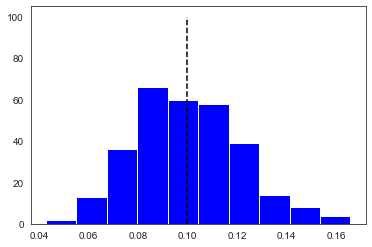

In [10]:
plt.hist(samples[:,0], color="blue")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=100)
plt.show()